# Discussion about cronjobs for expiring a secure element

In the following paragraphs I want to make a case for why the idea is bad. We will discuss the matter on a logical and mathematical basis and leave no hair unpicked. We will see how the idea is falling apart when the we apply the Nyquist-Shannon theorem. 

Brace.

First we import some plotting tools, which can be used to visually prove a point, if words should not suffice.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Sampling rates and their relationship with security

Sampling is a process of converting a signal (for example, a function of continuous time or space) into a sequence of values (a function of discrete time or space). One version of the theorem states:

> If a function $x ( t )$ contains no frequencies higher than $B$ hertz, then it can be completely determined from its ordinates at a sequence of points spaced less than $1 / ( 2 B )$ seconds apart. 

Mathematically, if $f_{max}$ is the highest frequency of the signal, the sampling rate $f_s$ must satisfy:

$f_s \geq 2 f_{max}$

This means that a continuous-time signal $x(t)$ can be sampled at a frequency $f_s$ in order to get a discrete-time copy $x[n]$ of it, and afterwards be reconstructed perfectly to its original form $x(t)$ if (and *ONLY* if) $f_{max}$ is the maximum frequency value of the $x(t)$ signal spectrum.

> The Nyquist–Shannon sampling theorem is an essential principle for digital signal processing linking the frequency range of a signal and the sample rate required to avoid a type of distortion called aliasing. The theorem states that the sample rate must be at least twice the bandwidth of the signal to avoid aliasing. In practice, it is used to select band-limiting filters to keep aliasing below an acceptable amount when an analog signal is sampled or when sample rates are changed within a digital signal processing function.

> Understanding the application of Nyquist-Shannon will help the head of operations to deal with promtheus metric alerts more efficiently


## Secure Elements and Expiration

Lets say our signal would be that of a security-citical process... what would Distortion or Aliasing mean here? 

If it is not obvious: it translates to an error with the expiration mechanic that at most amounts to $f_s - e$, where the epsilon is the smallest possible step of time after an expiration job suceeded. This is about 23 hours 59 minutes in the case cron is used. Cron has highest resolution of $1/60$s.

Since it was not obvious from words last meeting, I will now proceed to prove this point. [0]

Lets have some parameters for the different sampling rates of signal.

In [14]:
frequency = 5  # Frequency of the sine wave (Hz)
sampling_rate_well_above = 40
sampling_rate_above = 20  # Sampling rate above Nyquist rate (samples per second)
sampling_rate_at = 10  # Sampling rate at Nyquist rate (samples per second)
sampling_rate_below = 8  # Sampling rate below Nyquist rate (samples per second)
duration = 1  # Duration in seconds

Yes.. the chosen frequency in this example is not $1/24$ hours, but do not worry. Evidently the frequency value $f_{max}$ does only matter in relationship to the sampling rate $f_s$.

Later we will apply the following demonstration on our secure elements croning, but first please indulge me:

We need a time array for our continuous signals, to hold $t$ and $x(t)$:

In [17]:
t_continuous = np.linspace(0, duration, 1000)
y_continuous = np.sin(2 * np.pi * frequency * t_continuous)

Yes, this is not the same function as our expiration function. I will now justify why a sine wave is already enough to understand the problem, and you will not be able to weasel out of the truth by stating:

> akchually, the expiration function $g(t)$ is not equal to a sine wave!!!!!!11

Know this about signal theory: a sine wave is called a pure waveform because it does not carry any harmonics. The harmonics of a signal are all the frequencies which are not the fundamental frequency. Real world signals are not pure, they alway have harmonics. You could say the highest frequency in a sine wave is its fundamental frequency and it would sound pretty smart. [1]

But do not take my words for it... I have proof for you that you are unable to refute.

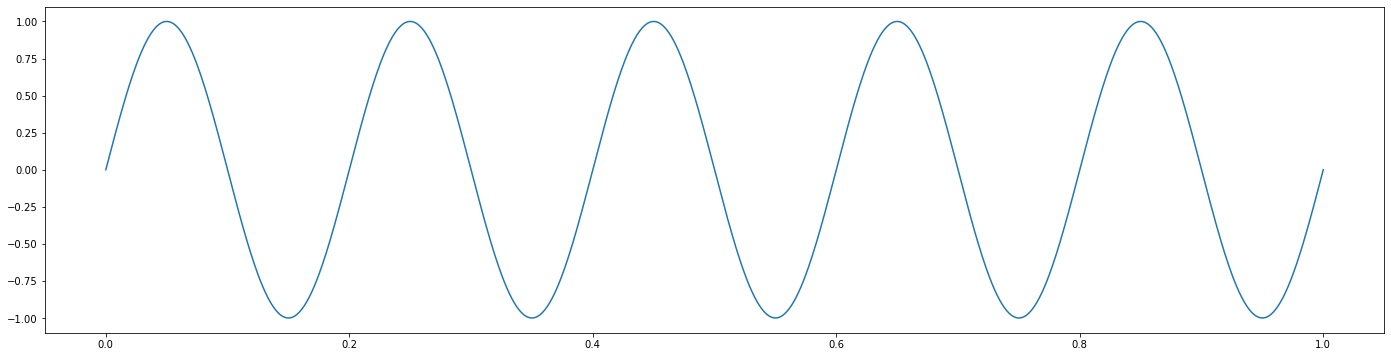

In [22]:
plt.figure(figsize=(24, 6))
_ = plt.plot(t_continuous, y_continuous, label='Sine Wave')

Acknowledge the purity of the wave. Yes it is a sine wave. It would sound very boring. Lets prove the point [1] from above via the magic of fourier transform:

#### but what is a Fourier transformation?

The mathematical intricacies of the Fourier Transform can be challenging, but the core concepts can be understood with some basic mathematical concepts.

The Fourier Transform is a mathematical operation that transforms a function of time (a signal) into a function of frequency. This means it takes a time-domain signal and breaks it down into the frequencies that make it up.

Basic Idea:
1. Sinewaves: Any signal can be represented as a sum of sine waves of different frequencies, amplitudes, and phases.
2. Time Domain vs. Frequency Domain: The time domain represents how a signal changes over time, while the frequency domain represents how much of each frequency is present in the signal.

Why is it Useful?

1. Frequency Analysis: It allows us to analyze the frequency content of signals, which is crucial in many fields like signal processing, audio engineering, and communications.
2. Filtering: By transforming signals to the frequency domain, we can easily filter out unwanted frequencies.
3. Compression: It helps in compressing data by focusing on the most important frequency components.

> You have to have appreciation for Fourier, denying his truths is like being a flat-earther that uses GPS for navigation.

> If the Fast Fourier Transform had been invented just a bit earlier, it may very well have led to a world without further nuclear weapons test. This historical tidbit does not belong to the scope of this paper and you may research this context on your own time.

> There is no `cat_pic.jpg` without the Fast Fourier Transform.

```
⠀ ／l、?
（ﾟ､ ｡ ７
⠀ l,‏‏‎ ‎‏‏‎ ‎‏‏‎ ‎‎~ヽ
  じしf_, )ノ 
```

### example FFT of our signal

In [68]:
from scipy.fft import fft, fftfreq

# Perform FFT
N = len(y_continuous)
yf = fft(y_continuous)
xf = fftfreq(N, 1 / 1000)

# Only keep the positive frequencies
xf = xf[:N // 2]
yf = np.abs(yf[:N // 2])

This performed a FFT of the signal and stored it as `xf`. Next one up is to show the frequency domain in a plot:

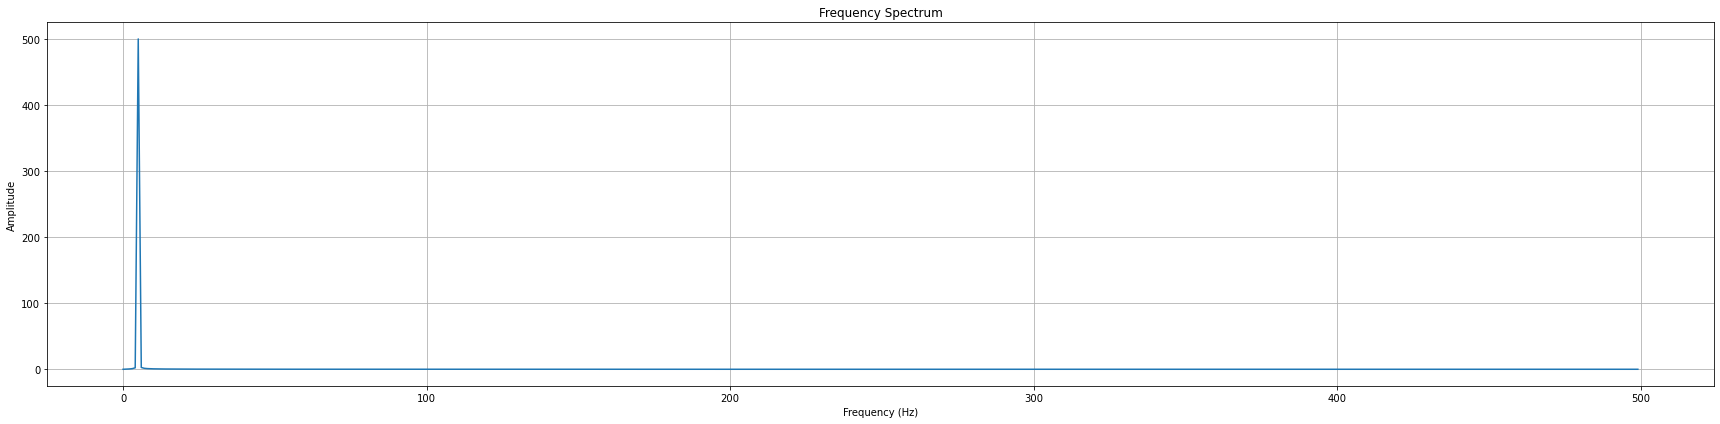

,Frequency (Hz),Amplitude
5,5.0,499.729241
6,6.0,2.742424
4,4.0,2.212014
7,7.0,1.462843
8,8.0,1.028011


In [69]:
plt.figure(figsize=(24, 6))
plt.plot(xf, yf, label='FFT of Sine Wave')
plt.title('Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

# Highlight frequency peaks
peaks_df = pd.DataFrame({
    'Frequency (Hz)': xf,
    'Amplitude': yf
}).sort_values(by='Amplitude', ascending=False).head(5)

peaks_df

We threw the negative results away. We will not need them. This is due to the imaginary number $i = \sqrt-1$ and the resulting rotations in the complex plane, which we will not explain here.

Observe that a strong & singular peak is present AND that the frequency with the highest amplitude is at 5 Hz. With the $FFT(x(t))$ we have a mathematical device to measure signals and their constituent parts.

We now have irrefutable proof for point [1], where we stated that the highest frequency in a sine waveform is the fundamental frequency of the signal to sound smart. Because my words arent trusted around here, we will go the extra mile and compose a new sine with another frequency mixed in for more visual proofs. Removing any leverage for future claims.

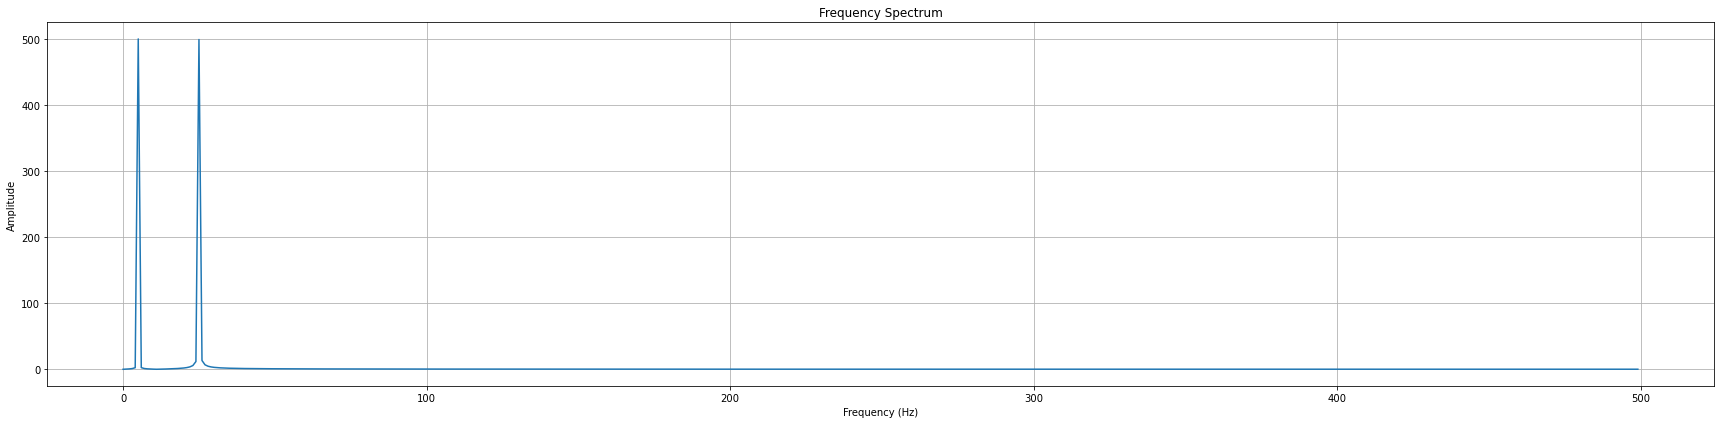

,Frequency (Hz),Amplitude
5,5.0,499.936929
25,25.0,499.025432
26,26.0,13.266616
24,24.0,11.720294
27,27.0,6.762562


In [70]:
y_continuous_mixed = np.sin(10 * np.pi * frequency * t_continuous) + y_continuous

N = len(y_continuous_mixed)
yf = fft(y_continuous_mixed)
xf = fftfreq(N, 1 / 1000)
xf = xf[:N // 2]
yf = np.abs(yf[:N // 2])
plt.figure(figsize=(24, 6))
plt.plot(xf, yf, label='FFT of Sine Wave')
plt.title('Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

# Highlight frequency peaks
peaks_df = pd.DataFrame({
    'Frequency (Hz)': xf,
    'Amplitude': yf
}).sort_values(by='Amplitude', ascending=False).head(5)

peaks_df

Yes, our FFT has identified the frequencies 5Hz and 25Hz. This is the expected result.

So... to fully prove that there was nothing factually wrong about any claims I made up to this point, I will generate a pulsewave, and its FFT, which will show a significant harmonic spectrum besides its fundamental. This will also show that all harmonics are above the fundamental frequency, which is a necessary prerequisite for concluding points 0,1 and 2.

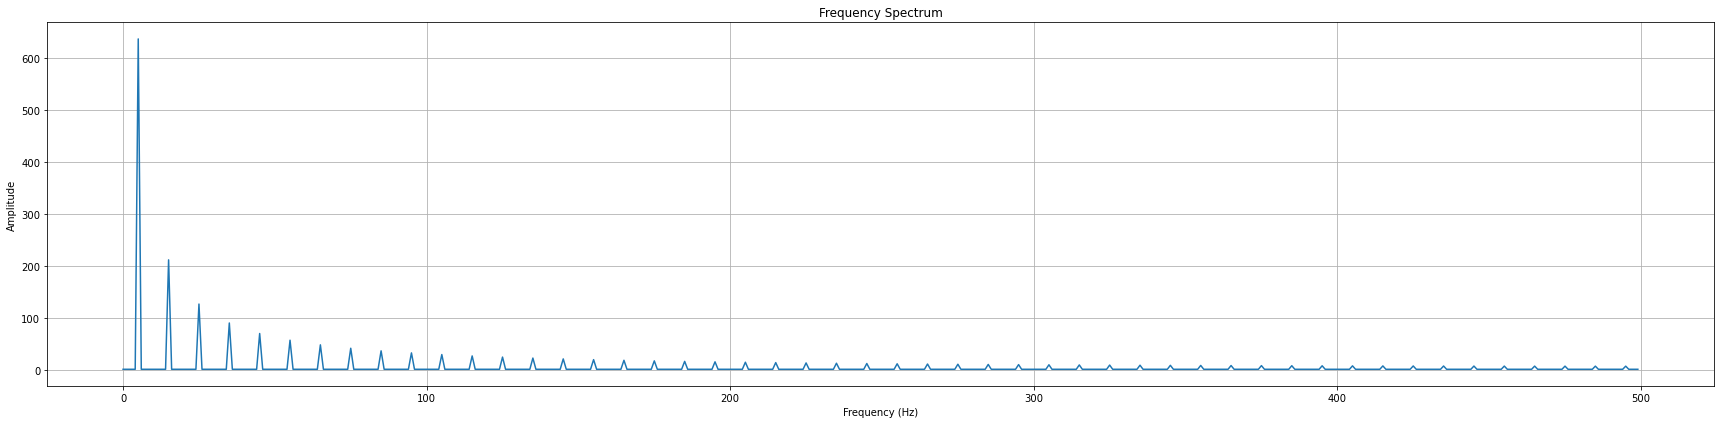

,Frequency (Hz),Amplitude
5,5.0,636.617679
15,15.0,212.200342
25,25.0,127.313644
35,35.0,90.931464
45,45.0,70.717623


In [71]:
from scipy import signal

square_wave = signal.square(2 * np.pi * frequency * t_continuous)


N = len(square_wave)
yf = fft(square_wave)
xf = fftfreq(N, 1 / 1000)
xf = xf[:N // 2]
yf = np.abs(yf[:N // 2])
plt.figure(figsize=(24, 6))
plt.plot(xf, yf, label='FFT of Sine Wave')
plt.title('Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

# Highlight frequency peaks
peaks_df = pd.DataFrame({
    'Frequency (Hz)': xf,
    'Amplitude': yf
}).sort_values(by='Amplitude', ascending=False).head(5)

peaks_df

Clearly, it has now been proven beyond any reasonable doubt, that point [1] is true. Any unreasonable doubt can be directed towards the tombstone of Jean-Baptiste Joseph Fourier, situated in the Père Lachaise Cemetery in Paris. It is the one with the egyptian motifs on it.

![](https://i.imgflip.com/8vyswp.jpg)

Now that the unreasonable people above 40 are traveling towards Paris, we could continue having a security discussion..  Though, the exposition of beauty can not just stop here. I honestly feel that I need to drive this point home.

Brace yourself, because when we are finished there will be no clouds or tombstones left to scream against.

My third Point [2] be, that the next plot approximates the expiration function $g(t)$, where a negative value means expired and a positive value means the device binding is still valid.

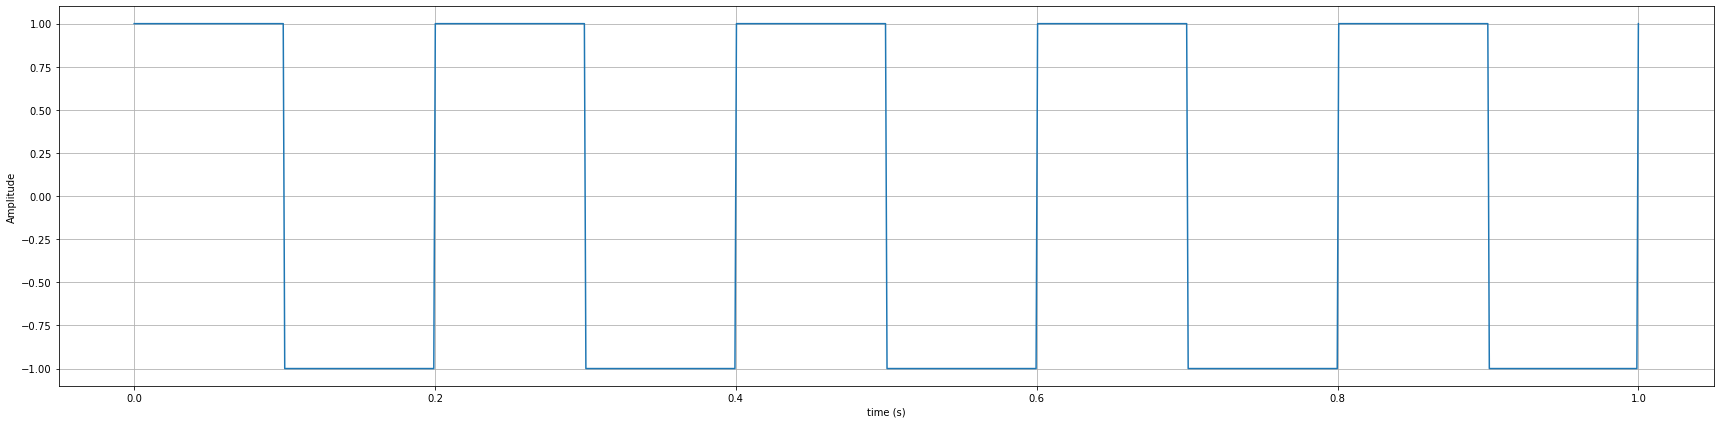

In [73]:
plt.figure(figsize=(24, 6))
plt.plot(t_continuous, square_wave, label='Square Wave')
plt.xlabel('time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()

For this function to map a real process, you have to convince a client to always refresh the device binding and then stop usage in equi-distant slices of time.

Of course, realworld clients do never act that way, but this detail was already completely lost in the discussion in meeting, where somebody unreasonably assumed that such clients use devices in equi-distant slices of time. Of course any proposition based on wrong assumptions can not lead to the truth, since

> ex contradictione sequitur quodlibet 

I just attached this [link](https://en.wikipedia.org/wiki/Principle_of_explosion) which will speak or itself.

In the following section, I will create new signals from the original sine waveform. I will adjust the samplerate $f_s$ for each signal, effectively simulating imperfect measurement method or erm... a cronjob that expires secure element with a resolution of 1/24h.

In [74]:
# Sampled time arrays
t_sampled_well_above = np.linspace(0, duration, int(sampling_rate_well_above * duration), endpoint=False)
t_sampled_above = np.linspace(0, duration, int(sampling_rate_above * duration), endpoint=False)
t_sampled_at = np.linspace(0, duration, int(sampling_rate_at * duration), endpoint=False)
t_sampled_below = np.linspace(0, duration, int(sampling_rate_below * duration), endpoint=False)

# Sampled sine waves
y_sampled_well_above = np.sin(2 * np.pi * frequency * t_sampled_well_above)
y_sampled_above = np.sin(2 * np.pi * frequency * t_sampled_above)
y_sampled_at = np.sin(2 * np.pi * frequency * t_sampled_at)
y_sampled_below = np.sin(2 * np.pi * frequency * t_sampled_below)

Pease note, that I have chosen $f_s$ such that, it lays well above the Nyquist frequency $2B$, then just above the frequency, then exactly at the Nyquist frequency and lastly is below the Nyquist frequency.

You will observe a series of graphs, showing the same sine curve measured with increasingly improper $f_s$. It is easy to see the Aliasing of the signal. Not hard to imagine, how this leads to improperly valid device bindings. But these are just words... am I right?

In [76]:
# Create a DataFrame for plotting
df = pd.DataFrame({
    't_continuous': t_continuous,
    'y_continuous': y_continuous,
    't_sampled_well_above': np.nan,
    'y_sampled_well_above': np.nan,
    't_sampled_above': np.nan,
    'y_sampled_above': np.nan,
    't_sampled_at': np.nan,
    'y_sampled_at': np.nan,
    't_sampled_below': np.nan,
    'y_sampled_below': np.nan
})

# Fill sampled values in the DataFrame
df.loc[df.index[:len(t_sampled_well_above)], 't_sampled_well_above'] = t_sampled_well_above
df.loc[df.index[:len(y_sampled_well_above)], 'y_sampled_well_above'] = y_sampled_well_above
df.loc[df.index[:len(t_sampled_above)], 't_sampled_above'] = t_sampled_above
df.loc[df.index[:len(y_sampled_above)], 'y_sampled_above'] = y_sampled_above
df.loc[df.index[:len(t_sampled_at)], 't_sampled_at'] = t_sampled_at
df.loc[df.index[:len(y_sampled_at)], 'y_sampled_at'] = y_sampled_at
df.loc[df.index[:len(t_sampled_below)], 't_sampled_below'] = t_sampled_below
df.loc[df.index[:len(y_sampled_below)], 'y_sampled_below'] = y_sampled_below

# Resampling the continuous signal
y_resampled_well_above = np.interp(t_continuous, t_sampled_well_above, y_sampled_well_above)
y_resampled_above = np.interp(t_continuous, t_sampled_above, y_sampled_above)
y_resampled_at = np.interp(t_continuous, t_sampled_at, y_sampled_at)
y_resampled_below = np.interp(t_continuous, t_sampled_below, y_sampled_below)


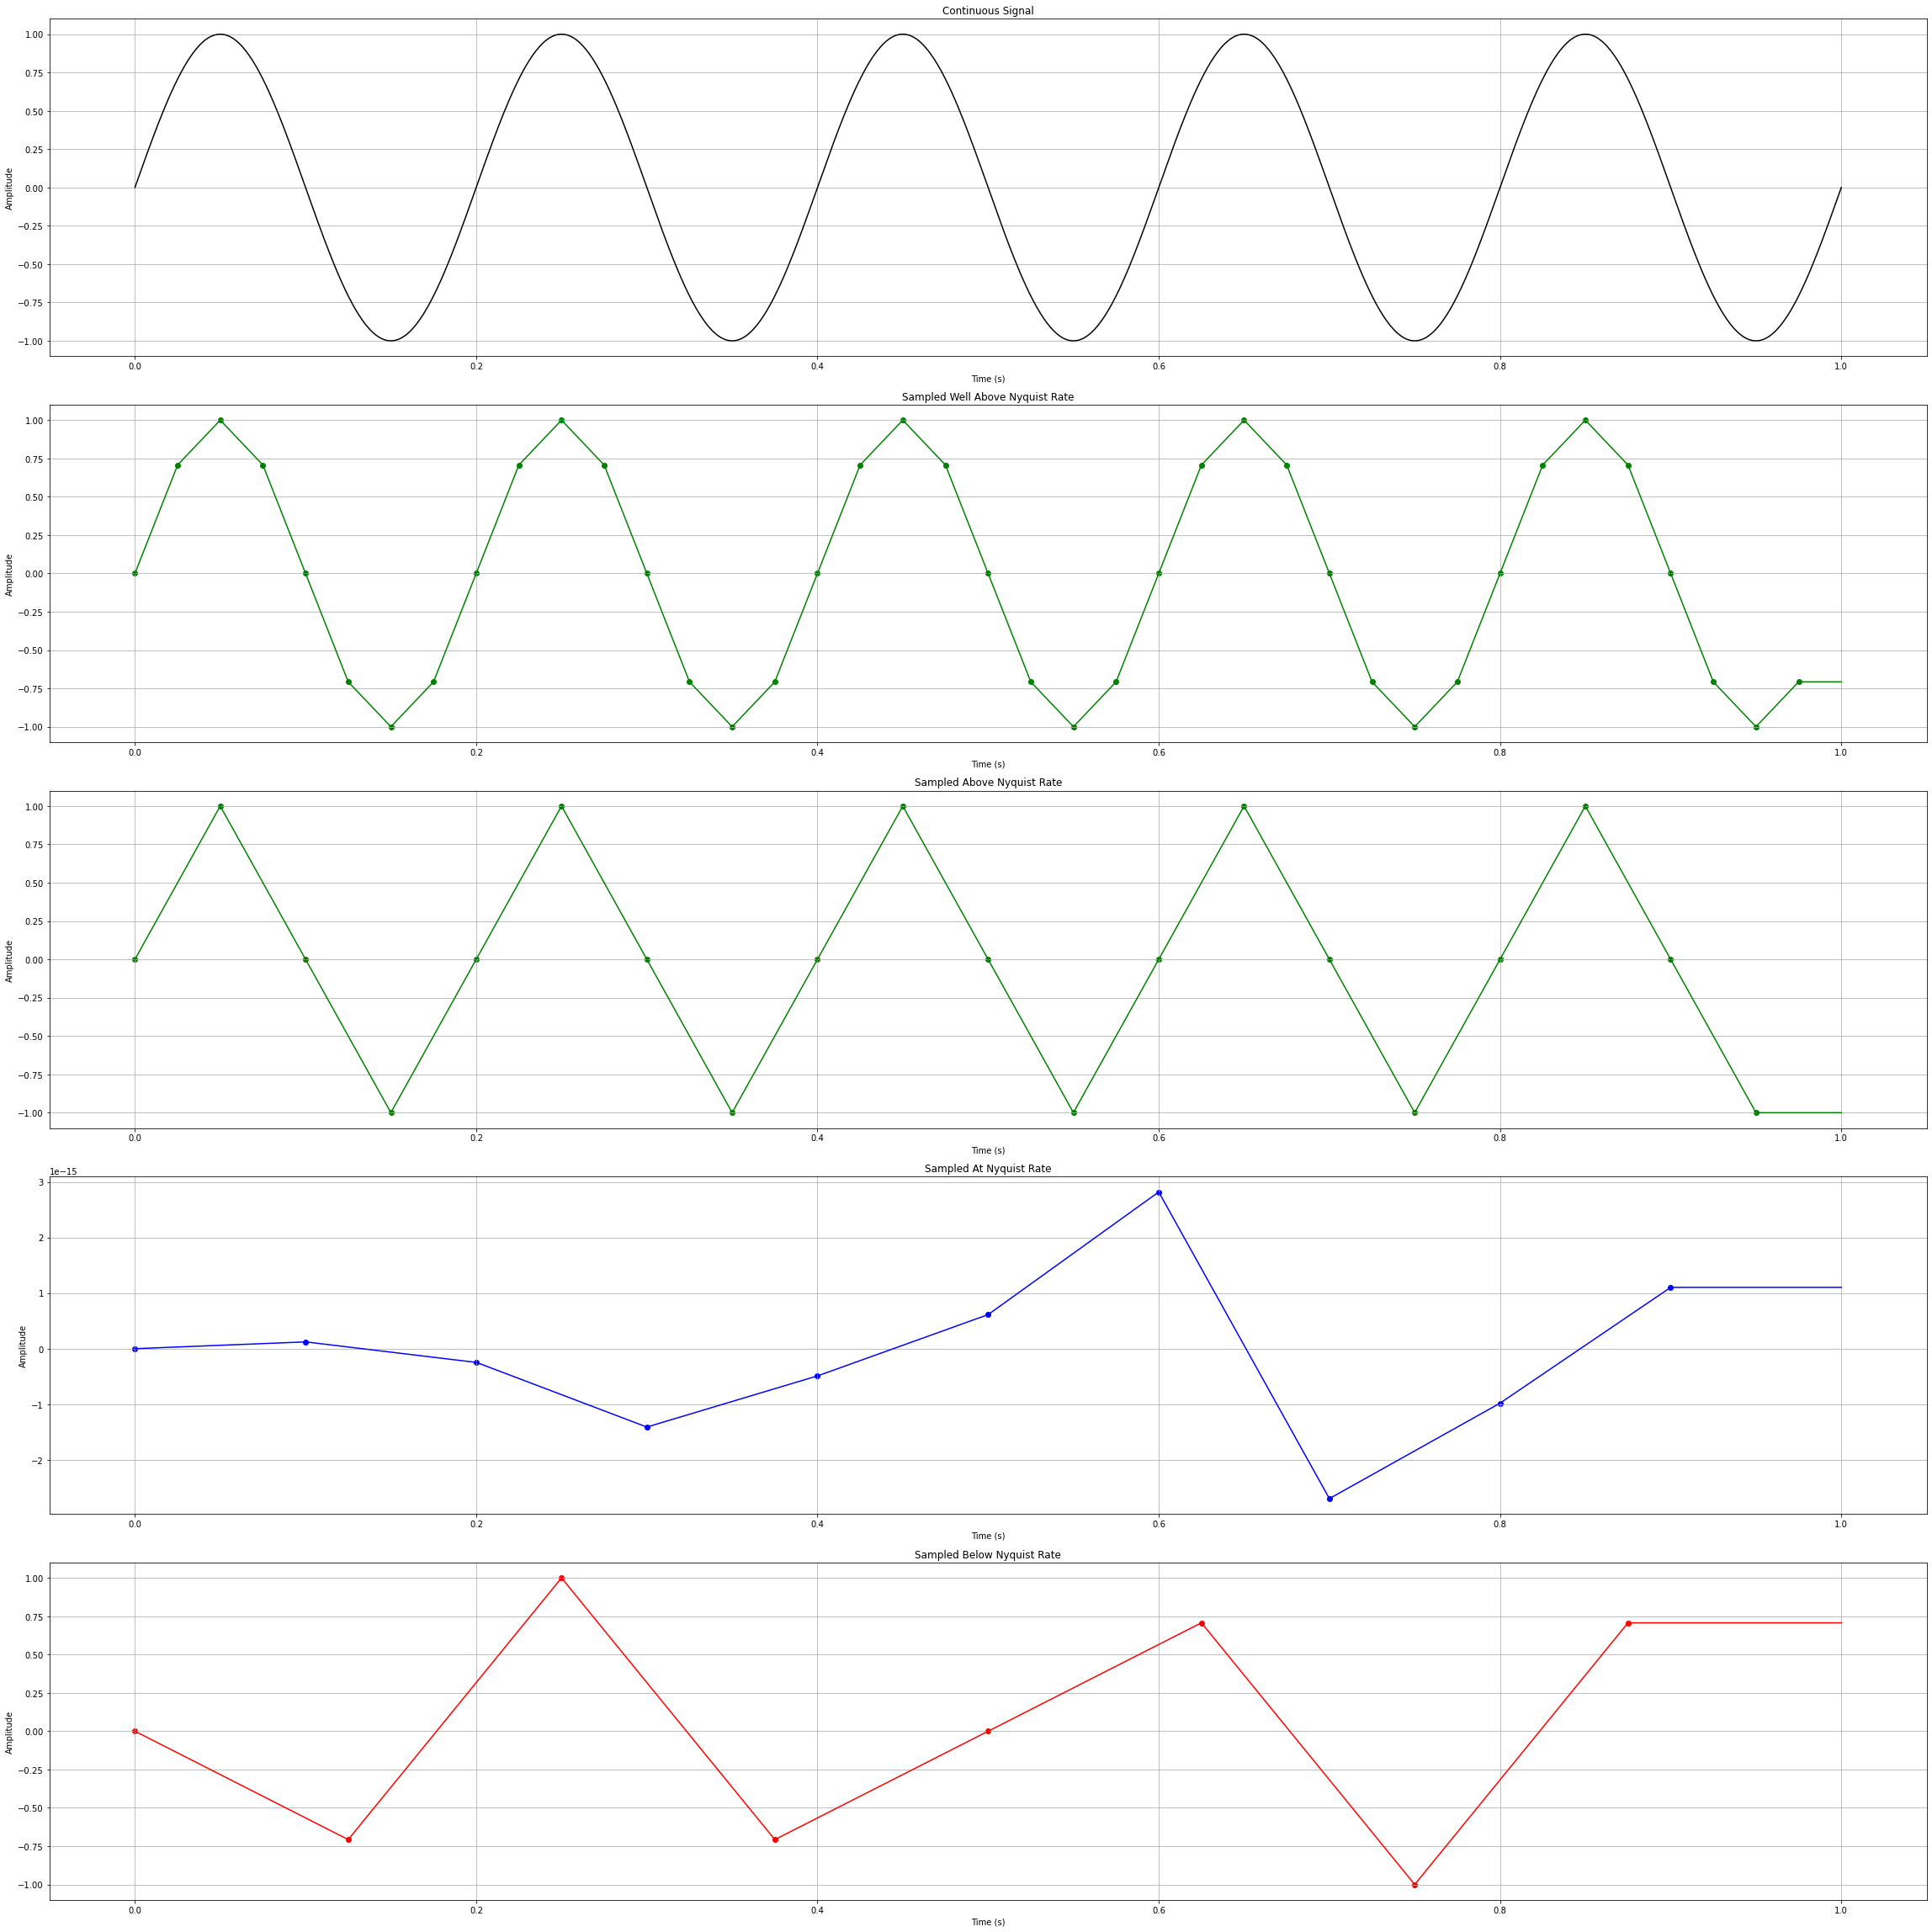

In [77]:
# Plotting
fig, axs = plt.subplots(5, 1, figsize=(32, 32))

# Continuous signal
axs[0].plot(df['t_continuous'], df['y_continuous'], label='Continuous Signal', color='black')
axs[0].set_title('Continuous Signal')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude')
axs[0].grid(True)

# Sampled well above Nyquist rate
axs[1].plot(df['t_continuous'], y_resampled_well_above, label='Resampled Signal (Well Above Nyquist)', color='green')
axs[1].scatter(df['t_sampled_well_above'], df['y_sampled_well_above'], color='green', marker='o')
axs[1].set_title('Sampled Well Above Nyquist Rate')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Amplitude')
axs[1].grid(True)

# Sampled above Nyquist rate
axs[2].plot(df['t_continuous'], y_resampled_above, label='Resampled Signal (Above Nyquist)', color='green')
axs[2].scatter(df['t_sampled_above'], df['y_sampled_above'], color='green', marker='o')
axs[2].set_title('Sampled Above Nyquist Rate')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Amplitude')
axs[2].grid(True)

# Sampled at Nyquist rate
axs[3].plot(df['t_continuous'], y_resampled_at, label='Resampled Signal (At Nyquist)', color='blue')
axs[3].scatter(df['t_sampled_at'], df['y_sampled_at'], color='blue', marker='o')
axs[3].set_title('Sampled At Nyquist Rate')
axs[3].set_xlabel('Time (s)')
axs[3].set_ylabel('Amplitude')
axs[3].grid(True)

# Sampled below Nyquist rate
axs[4].plot(df['t_continuous'], y_resampled_below, label='Resampled Signal (Below Nyquist)', color='red')
axs[4].scatter(df['t_sampled_below'], df['y_sampled_below'], color='red', marker='o')
axs[4].set_title('Sampled Below Nyquist Rate')
axs[4].set_xlabel('Time (s)')
axs[4].set_ylabel('Amplitude')
axs[4].grid(True)

plt.tight_layout()
plt.show()

The cronjob can only expire the device binding, when $g(t)<0$

1. You can _clearly_ recognize how a lower samplerate will lead to low fidelity signals, loosing information and overall just wrong data. Imagine one would use this last curve as expiration function.
2. The Fourier Transformation and the Resampling of a signal that has $f_{max}>2B$ is lossy.


Ok, these were difficult concepts, lets break it down to a simple comparision of two dimensionless numbers:

> Item A will be the last and worst graph from above (the one in red), which has the lowes samplerate of our thought experiment, and Item B will be the proposed Solution which we discussed.

So Item A is a sine wave over a period of one second. Within this second of time array, we created 1000 values for the sine. We say the Samplerate is 1000. When we used the lowest samplerate below Nyquist, we just had 8 data points left.

In [82]:
1000-(8/1000)

999.992

We have lost indeed 99.9992% of the signal.

Item B is a expiration value, stored as a Datetime. Datetimes technically have a resolution of at least milliseconds. Lets compute:

There are 86400000 milliseconds per day, which we will need to properly measure the expiration time. Lets cut our Cronner a bit of slack and we will drop the last three digits. That means we are left with 86400 samples. If we now only measure/cron once per day, then our samplerate will be only 1/86400 of possible samples. That is not only below the Nyquist frequency..

In [98]:
100 - ((1/86400000) * 100)

99.99999884259259

... it throws away 3 orders of magnitude, 1000x more than the worst case thought experiment, 

> we were gracious and granted another 1000x by forgetting milliseconds.. 

### evaluation

By choosing an improper sampling period the operation/the operator/the head of operations is going to distort the signal and will introduce Aliasing.

Aliasing is to be avoided. It sounds bad in music, it looks bad in computer games, and I personally will make an issue for our overlords and a related Risk ticket, mentioning the people personally who eagerly are speaking words like "I carry this responsiblilty".

I would also write into such ticket, that the only expert in Fast Fourier Transforms, curve discussions and formal logic was silenced in a meeting by the great Responsibility Bearer.

However, I have made irrefutable proofs for point 2 and 3 and have demonstrated how a proper measurement must take frequency and sample rate into account. I could rest the case here, but nope, here is more to say.

1. The case I have made is true for all frequencies and all waveforms
2. One of us has forgotten how security works & how secure session expiration must work.
3. The same person is above 40 and has unhealthy relationship with cronjobs.

> If you only know a hammer, then all problems looks like a nail.



## Final proof

![](https://i.ibb.co/gR35d4J/teenager.png)